# 🏠Predicting the Sale Price of Housing in Paris


## 1. Problem Definition
I want to use know and predict the sale price of housing in paris using suitable machine learning algorithm 

## 2. Data
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Paris Housing Price Prediction. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance. https://www.kaggle.com/competitions/playground-series-s3e6/data

## 3. Evaluation
The model will be evaluated using Root Mean Squared Error (RMSE) https://www.kaggle.com/competitions/playground-series-s3e6/overview
After evaluating will need to check the leaderboard to know what we scored, the submissions will scored on the root mean squared error https://www.kaggle.com/competitions/playground-series-s3e6/leaderboard

In [1]:
# import the necessary libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# import models 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRFRegressor

# mdoel evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# feature engineering
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = pd.read_csv("playground-series-s3e6/train.csv")
df.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [3]:
# check the total number of rows and columns with the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 22730 non-null  int64  
 1   squareMeters       22730 non-null  int64  
 2   numberOfRooms      22730 non-null  int64  
 3   hasYard            22730 non-null  int64  
 4   hasPool            22730 non-null  int64  
 5   floors             22730 non-null  int64  
 6   cityCode           22730 non-null  int64  
 7   cityPartRange      22730 non-null  int64  
 8   numPrevOwners      22730 non-null  int64  
 9   made               22730 non-null  int64  
 10  isNewBuilt         22730 non-null  int64  
 11  hasStormProtector  22730 non-null  int64  
 12  basement           22730 non-null  int64  
 13  attic              22730 non-null  int64  
 14  garage             22730 non-null  int64  
 15  hasStorageRoom     22730 non-null  int64  
 16  hasGuestRoom       227

In [4]:
# check if there is a missing value
df.isna().max()

id                   False
squareMeters         False
numberOfRooms        False
hasYard              False
hasPool              False
floors               False
cityCode             False
cityPartRange        False
numPrevOwners        False
made                 False
isNewBuilt           False
hasStormProtector    False
basement             False
attic                False
garage               False
hasStorageRoom       False
hasGuestRoom         False
price                False
dtype: bool

In [5]:
df.isnull().sum().max()

0

In [6]:
# length of index
len(df)

22730

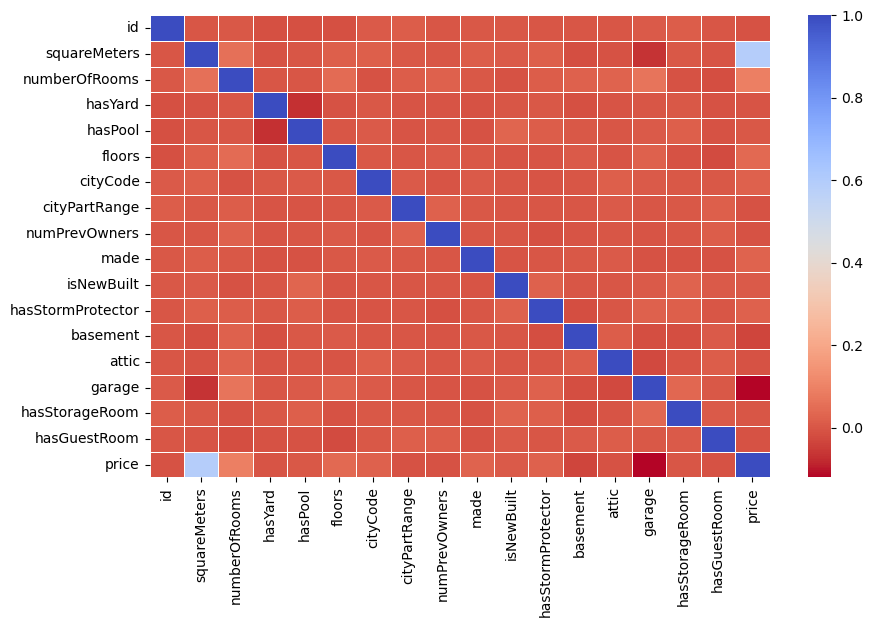

In [7]:
# correlation matrix
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_corr, annot_kws = {'size': 20}, linewidths = 0.5, fmt = '.2f', cmap= 'coolwarm_r')
ax.set_xticklabels(df_corr);

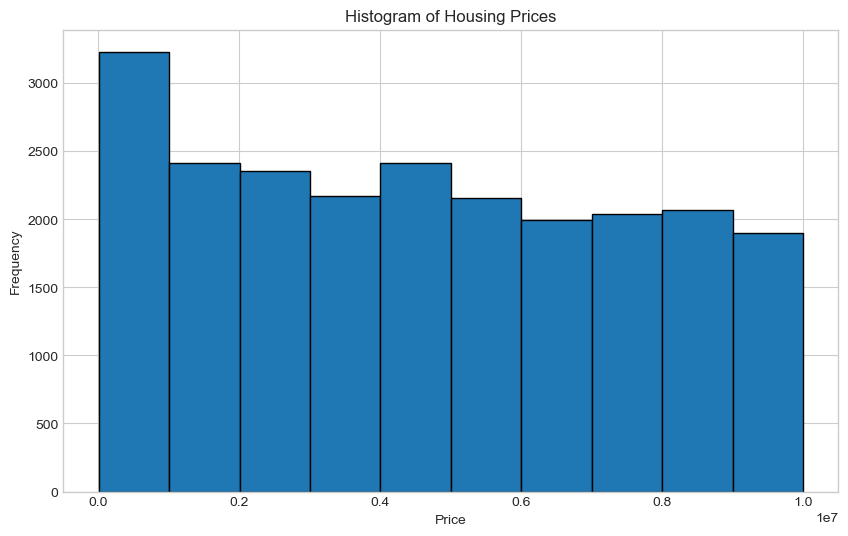

In [8]:
plt.style.use('seaborn-v0_8-whitegrid')
# Histogram for Price
plt.figure(figsize=(10, 6))
plt.hist(df["price"], bins=10, edgecolor='k')
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histogram of Housing Prices")
plt.show()

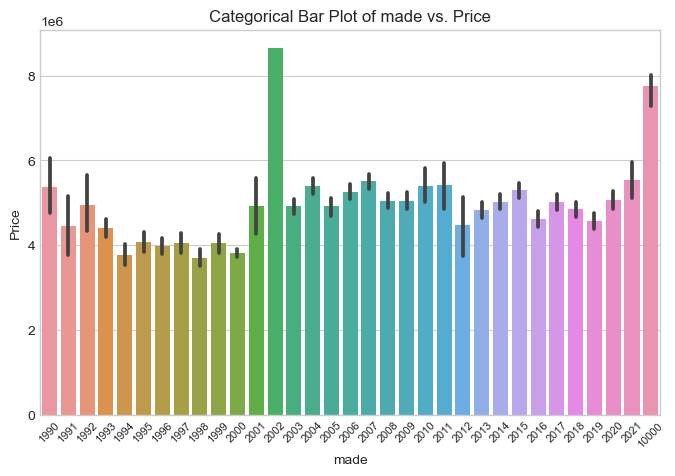

In [9]:
# Categorical Bar plot for hasYard vs. Price
plt.figure(figsize=(8, 5))
sns.barplot(x="made", y="price", data=df)
plt.xlabel("made")
plt.ylabel("Price")
plt.title("Categorical Bar Plot of made vs. Price")
plt.xticks(rotation= 45, fontsize = 8)
plt.show()

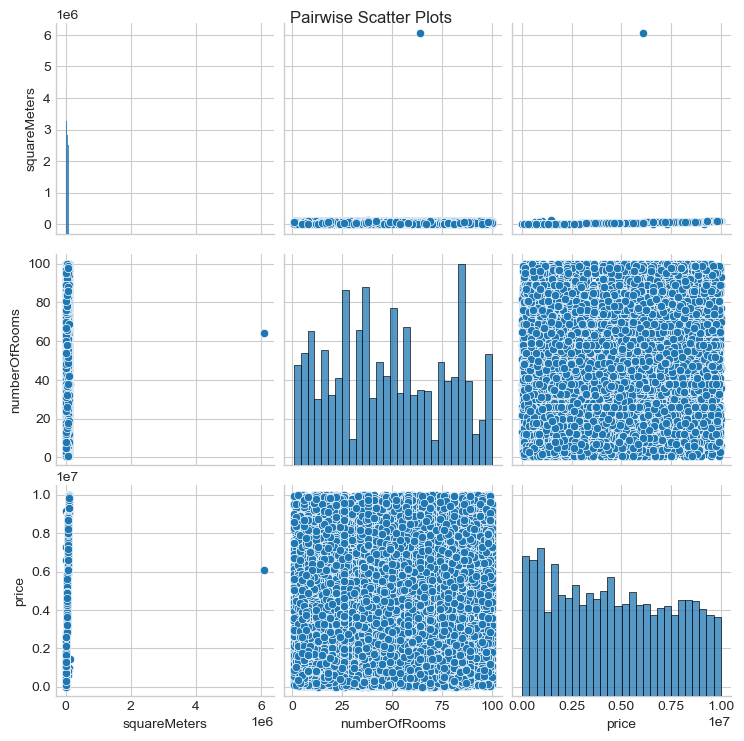

In [10]:

# Pair Plots (Pairwise Scatter Plots)
sns.pairplot(df, vars=["squareMeters", "numberOfRooms", "price"])
plt.suptitle("Pairwise Scatter Plots")
plt.show()

#### Preprocessing the data, to improve our model prediction

In [11]:
categorical_features = [
    'hasYard', 'hasPool', 'cityCode', 'made',
    'isNewBuilt', 'hasStormProtector',
    'hasStorageRoom', 'hasGuestRoom'
]

numerical_features = [
    'squareMeters', 'floors', 'garage', 'basement', 'attic', 'numberOfRooms', 'cityPartRange',
    'numPrevOwners', 
]

# Define the transformer for both category and numerical
one_hot = OneHotEncoder(handle_unknown='ignore')
std_scaler = StandardScaler()

# create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', std_scaler, numerical_features),
        ('cat', one_hot, categorical_features)
    ],
    remainder= 'passthrough')

In [12]:
# split the data X and y 
X = df.drop('price', axis = 1)
y= df.price

## Modelling

In [13]:
# we can use the tran_test_split since it is not a time series
# split the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)
X_train.shape, X_test.shape

((18184, 17), (4546, 17))

In [14]:
# Create dictionary of model instances, there should be 4 total key, value pairs
# in the form {"model_name": model_instance}.
# Don't forget there's two versions of SVR, one with a "linear" kernel and the
# other with kernel set to "rbf".
regression_models = {"Ridge": Ridge(),
                     "SVR_linear": SVR(kernel= 'linear'),
                     "SVR_rbf": SVR(kernel= 'rbf'),
                     "RandomForestRegressor": RandomForestRegressor()}

# Create an empty dictionary for the regression results
regression_results = {}

# Loop through the items in the regression_models dictionary
for model_name, model in regression_models.items():
    
    # Create a model Pipeline with a preprocessor step and model step
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)])
    
    # Fit the model Pipeline to the car sales training data
    print(f"Fitting {model_name}...")
    model_pipeline.fit(X_train, y_train)
    
    # Score the model Pipeline on the test data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    regression_results[model_name] = model_pipeline.score(X_test, 
                                                          y_test)

# Check the results of each regression model by printing the regression_results
# dictionary
regression_results

Fitting Ridge...
Scoring Ridge...
Fitting SVR_linear...
Scoring SVR_linear...
Fitting SVR_rbf...
Scoring SVR_rbf...
Fitting RandomForestRegressor...
Scoring RandomForestRegressor...


{'Ridge': 0.4735356696074825,
 'SVR_linear': -0.000490645213521157,
 'SVR_rbf': -0.004086632068655671,
 'RandomForestRegressor': 0.9969244881343174}

In [15]:
# create the function for rsme

def rmse(y_test, y_preds):
    return np.sqrt(mean_squared_error(y_test, y_preds))

### Model Evaluation & Experimenting

In [18]:
# using randomsearchcv and gridsearchcv to tune the hyperparameters of the models

rf_grid = {'model__n_estimators': np.arange(10,100,10),
          'model__max_depth': [None, 3, 5, 10],
          'model__min_samples_split': np.arange(2, 20, 2),
          'model__min_samples_leaf': np.arange(1, 20, 2),
          'model__max_features': [0.5, 1, 'sqrt', 'auto'],
          'model__max_samples': [10000]}


# create a pipeline for the columns and apply a model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())])

rf_model = RandomizedSearchCV(rf_pipeline, 
                              param_distributions= rf_grid,
                              n_iter= 20,
                              cv= 5, random_state= 42,
                              verbose= True)

# fit the randomforest pipeline the the dataset
rf_model.fit(X_train, y_train)

rf_best= rf_model.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [19]:
# Randomforest
y_preds = rf_best.predict(X_test)
rmse2 = rmse(y_test, y_preds)
r2 = r2_score(y_test, y_preds)
print(f"RMSE : {rmse2 : .2f}"
      f"\nR2 : {r2}")

RMSE :  163025.57
R2 : 0.9969247914496557


In [20]:
# catboost
cat = CatBoostRegressor()

cat_grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
cat_model = RandomizedSearchCV(cat,
                               param_distributions= cat_grid,
                               random_state=42, n_iter= 10, cv = 5)

# Create a pipeline for CatBoost
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', cat_model)])
catboost_pipeline.fit(X_train, y_train)


0:	learn: 2837127.0101708	total: 195ms	remaining: 29s
1:	learn: 2758023.6656358	total: 242ms	remaining: 17.9s
2:	learn: 2678419.5025246	total: 290ms	remaining: 14.2s
3:	learn: 2603528.5362454	total: 353ms	remaining: 12.9s
4:	learn: 2529607.8540144	total: 420ms	remaining: 12.2s
5:	learn: 2458101.3742029	total: 469ms	remaining: 11.3s
6:	learn: 2389047.8124045	total: 522ms	remaining: 10.7s
7:	learn: 2321902.4804417	total: 565ms	remaining: 10s
8:	learn: 2256990.6992617	total: 609ms	remaining: 9.54s
9:	learn: 2193731.6155578	total: 663ms	remaining: 9.29s
10:	learn: 2133524.3757623	total: 712ms	remaining: 8.99s
11:	learn: 2072971.2387063	total: 776ms	remaining: 8.92s
12:	learn: 2014795.1236287	total: 833ms	remaining: 8.78s
13:	learn: 1958595.4067483	total: 891ms	remaining: 8.66s
14:	learn: 1903630.5109220	total: 936ms	remaining: 8.43s
15:	learn: 1850957.5119941	total: 983ms	remaining: 8.23s
16:	learn: 1798243.3785141	total: 1.03s	remaining: 8.05s
17:	learn: 1746719.5077150	total: 1.08s	remai

146:	learn: 129898.9220197	total: 8.07s	remaining: 165ms
147:	learn: 128754.6901252	total: 8.12s	remaining: 110ms
148:	learn: 127663.0557990	total: 8.17s	remaining: 54.8ms
149:	learn: 126541.2815326	total: 8.21s	remaining: 0us
0:	learn: 2840711.5192959	total: 47.1ms	remaining: 7.01s
1:	learn: 2761863.5096799	total: 89ms	remaining: 6.59s
2:	learn: 2685543.2549790	total: 135ms	remaining: 6.6s
3:	learn: 2608385.3891091	total: 183ms	remaining: 6.66s
4:	learn: 2533646.6018967	total: 227ms	remaining: 6.59s
5:	learn: 2463092.4782093	total: 274ms	remaining: 6.57s
6:	learn: 2394612.5904565	total: 319ms	remaining: 6.51s
7:	learn: 2326086.8861569	total: 364ms	remaining: 6.46s
8:	learn: 2259117.5991549	total: 411ms	remaining: 6.44s
9:	learn: 2196810.6679268	total: 458ms	remaining: 6.42s
10:	learn: 2134843.7467782	total: 488ms	remaining: 6.17s
11:	learn: 2076065.6241390	total: 537ms	remaining: 6.17s
12:	learn: 2017423.7288139	total: 584ms	remaining: 6.15s
13:	learn: 1961509.6827589	total: 630ms	rem

142:	learn: 112561.2129303	total: 7.35s	remaining: 360ms
143:	learn: 111138.8641644	total: 7.4s	remaining: 308ms
144:	learn: 109902.0784082	total: 7.44s	remaining: 257ms
145:	learn: 108663.4033702	total: 7.49s	remaining: 205ms
146:	learn: 107298.4331078	total: 7.53s	remaining: 154ms
147:	learn: 106034.8274914	total: 7.57s	remaining: 102ms
148:	learn: 104818.5784498	total: 7.62s	remaining: 51.1ms
149:	learn: 103675.6512539	total: 7.66s	remaining: 0us
0:	learn: 2842893.1651372	total: 49.8ms	remaining: 7.42s
1:	learn: 2763758.8170818	total: 103ms	remaining: 7.62s
2:	learn: 2685062.7378143	total: 147ms	remaining: 7.21s
3:	learn: 2609098.0512312	total: 195ms	remaining: 7.1s
4:	learn: 2534413.1191627	total: 247ms	remaining: 7.17s
5:	learn: 2462756.2069121	total: 297ms	remaining: 7.12s
6:	learn: 2392375.6143490	total: 345ms	remaining: 7.05s
7:	learn: 2324269.2857778	total: 401ms	remaining: 7.12s
8:	learn: 2257108.0039838	total: 447ms	remaining: 7s
9:	learn: 2193781.0109706	total: 501ms	remain

142:	learn: 123640.2820054	total: 7.19s	remaining: 352ms
143:	learn: 121983.6861252	total: 7.24s	remaining: 302ms
144:	learn: 120835.5686739	total: 7.28s	remaining: 251ms
145:	learn: 119675.3443843	total: 7.32s	remaining: 201ms
146:	learn: 118507.1387947	total: 7.38s	remaining: 151ms
147:	learn: 117331.0707513	total: 7.42s	remaining: 100ms
148:	learn: 116200.5225309	total: 7.47s	remaining: 50.1ms
149:	learn: 115032.3502028	total: 7.51s	remaining: 0us
0:	learn: 2838067.5014256	total: 49.7ms	remaining: 7.41s
1:	learn: 2757012.6881864	total: 94.4ms	remaining: 6.99s
2:	learn: 2680622.6467720	total: 138ms	remaining: 6.78s
3:	learn: 2604531.3424090	total: 184ms	remaining: 6.71s
4:	learn: 2532218.0873761	total: 239ms	remaining: 6.93s
5:	learn: 2462020.5643179	total: 295ms	remaining: 7.09s
6:	learn: 2393824.1515976	total: 337ms	remaining: 6.88s
7:	learn: 2325632.3733707	total: 382ms	remaining: 6.79s
8:	learn: 2260128.1521648	total: 431ms	remaining: 6.76s
9:	learn: 2196005.2363190	total: 479ms	

141:	learn: 134098.1034930	total: 7.43s	remaining: 419ms
142:	learn: 132708.1376961	total: 7.49s	remaining: 366ms
143:	learn: 131425.5225562	total: 7.53s	remaining: 314ms
144:	learn: 130030.5028803	total: 7.58s	remaining: 261ms
145:	learn: 128583.0657226	total: 7.62s	remaining: 209ms
146:	learn: 127397.3351785	total: 7.67s	remaining: 157ms
147:	learn: 126122.8648548	total: 7.72s	remaining: 104ms
148:	learn: 124861.3746791	total: 7.78s	remaining: 52.2ms
149:	learn: 123737.5968959	total: 7.85s	remaining: 0us
0:	learn: 2833505.8334695	total: 50.4ms	remaining: 7.51s
1:	learn: 2752051.0831550	total: 106ms	remaining: 7.84s
2:	learn: 2674061.2864280	total: 167ms	remaining: 8.18s
3:	learn: 2599684.7068260	total: 223ms	remaining: 8.14s
4:	learn: 2526342.3420550	total: 286ms	remaining: 8.3s
5:	learn: 2454893.7969152	total: 348ms	remaining: 8.35s
6:	learn: 2384822.7124636	total: 410ms	remaining: 8.37s
7:	learn: 2316550.9302368	total: 476ms	remaining: 8.44s
8:	learn: 2250422.8032140	total: 529ms	r

140:	learn: 142541.1980761	total: 7.35s	remaining: 469ms
141:	learn: 140998.9244960	total: 7.42s	remaining: 418ms
142:	learn: 139669.5319785	total: 7.47s	remaining: 366ms
143:	learn: 138364.4124388	total: 7.53s	remaining: 314ms
144:	learn: 137092.2720180	total: 7.58s	remaining: 261ms
145:	learn: 135663.3190782	total: 7.62s	remaining: 209ms
146:	learn: 134329.1697165	total: 7.67s	remaining: 156ms
147:	learn: 133164.5203597	total: 7.71s	remaining: 104ms
148:	learn: 131953.4006071	total: 7.75s	remaining: 52.1ms
149:	learn: 130776.5433392	total: 7.8s	remaining: 0us
0:	learn: 2645423.8800233	total: 43.6ms	remaining: 4.31s
1:	learn: 2397511.7525473	total: 90ms	remaining: 4.41s
2:	learn: 2170862.1483155	total: 138ms	remaining: 4.46s
3:	learn: 1969537.4648982	total: 202ms	remaining: 4.85s
4:	learn: 1785852.8299292	total: 256ms	remaining: 4.87s
5:	learn: 1616567.6055405	total: 306ms	remaining: 4.79s
6:	learn: 1469852.4581285	total: 351ms	remaining: 4.66s
7:	learn: 1332119.2430094	total: 397ms	r

41:	learn: 144149.4805877	total: 2.11s	remaining: 2.91s
42:	learn: 139627.8981534	total: 2.16s	remaining: 2.87s
43:	learn: 135876.5754701	total: 2.21s	remaining: 2.81s
44:	learn: 132273.4405178	total: 2.26s	remaining: 2.76s
45:	learn: 128881.5484134	total: 2.31s	remaining: 2.71s
46:	learn: 126171.9913580	total: 2.36s	remaining: 2.66s
47:	learn: 123423.1836689	total: 2.4s	remaining: 2.6s
48:	learn: 120976.8844749	total: 2.45s	remaining: 2.55s
49:	learn: 118825.9393461	total: 2.5s	remaining: 2.5s
50:	learn: 116697.6360299	total: 2.55s	remaining: 2.45s
51:	learn: 114560.2786662	total: 2.6s	remaining: 2.4s
52:	learn: 112702.7988739	total: 2.65s	remaining: 2.35s
53:	learn: 110977.4006343	total: 2.69s	remaining: 2.29s
54:	learn: 109258.2979047	total: 2.74s	remaining: 2.24s
55:	learn: 107897.6554823	total: 2.79s	remaining: 2.19s
56:	learn: 106329.0577081	total: 2.84s	remaining: 2.14s
57:	learn: 104953.8927845	total: 2.88s	remaining: 2.09s
58:	learn: 103606.0881318	total: 2.93s	remaining: 2.03

91:	learn: 87607.6886846	total: 4.46s	remaining: 388ms
92:	learn: 86842.0316859	total: 4.51s	remaining: 339ms
93:	learn: 85523.3600919	total: 4.56s	remaining: 291ms
94:	learn: 85146.3918269	total: 4.6s	remaining: 242ms
95:	learn: 84704.9256651	total: 4.65s	remaining: 194ms
96:	learn: 83723.6415609	total: 4.69s	remaining: 145ms
97:	learn: 83215.7926176	total: 4.74s	remaining: 96.8ms
98:	learn: 82902.4290224	total: 4.78s	remaining: 48.3ms
99:	learn: 82632.9329308	total: 4.82s	remaining: 0us
0:	learn: 2644560.2313976	total: 51.1ms	remaining: 5.06s
1:	learn: 2394936.8072179	total: 96.8ms	remaining: 4.74s
2:	learn: 2176581.3133071	total: 150ms	remaining: 4.85s
3:	learn: 1968518.3877467	total: 197ms	remaining: 4.72s
4:	learn: 1787619.6948565	total: 242ms	remaining: 4.59s
5:	learn: 1622947.4895069	total: 288ms	remaining: 4.51s
6:	learn: 1471764.6502433	total: 337ms	remaining: 4.48s
7:	learn: 1336133.7879745	total: 396ms	remaining: 4.56s
8:	learn: 1215108.8032245	total: 453ms	remaining: 4.58s


42:	learn: 166898.1526657	total: 2.17s	remaining: 2.88s
43:	learn: 163992.0299247	total: 2.22s	remaining: 2.82s
44:	learn: 160298.3311119	total: 2.28s	remaining: 2.79s
45:	learn: 156959.1533330	total: 2.33s	remaining: 2.73s
46:	learn: 153873.7921414	total: 2.38s	remaining: 2.68s
47:	learn: 151050.2154885	total: 2.43s	remaining: 2.63s
48:	learn: 148656.2537940	total: 2.47s	remaining: 2.57s
49:	learn: 146394.3928945	total: 2.52s	remaining: 2.52s
50:	learn: 144189.1751928	total: 2.57s	remaining: 2.47s
51:	learn: 142280.4153507	total: 2.62s	remaining: 2.42s
52:	learn: 140303.2145164	total: 2.68s	remaining: 2.37s
53:	learn: 138371.3745925	total: 2.73s	remaining: 2.33s
54:	learn: 136568.2130923	total: 2.79s	remaining: 2.28s
55:	learn: 134886.7566876	total: 2.84s	remaining: 2.23s
56:	learn: 133380.1118444	total: 2.88s	remaining: 2.17s
57:	learn: 131395.6864882	total: 2.94s	remaining: 2.13s
58:	learn: 130191.1714057	total: 2.98s	remaining: 2.07s
59:	learn: 128396.6211849	total: 3.04s	remaining

92:	learn: 68908.2070995	total: 5.21s	remaining: 392ms
93:	learn: 68246.8782108	total: 5.26s	remaining: 336ms
94:	learn: 67811.4991807	total: 5.31s	remaining: 279ms
95:	learn: 67254.2527587	total: 5.36s	remaining: 224ms
96:	learn: 66543.5219846	total: 5.42s	remaining: 168ms
97:	learn: 66194.6239186	total: 5.47s	remaining: 112ms
98:	learn: 65631.5945247	total: 5.54s	remaining: 55.9ms
99:	learn: 65021.4375074	total: 5.59s	remaining: 0us
0:	learn: 2643818.5799049	total: 47.4ms	remaining: 4.7s
1:	learn: 2397702.5983303	total: 96.4ms	remaining: 4.72s
2:	learn: 2179297.1479016	total: 150ms	remaining: 4.85s
3:	learn: 1973743.1634831	total: 206ms	remaining: 4.96s
4:	learn: 1790033.5758435	total: 259ms	remaining: 4.92s
5:	learn: 1624699.0083586	total: 308ms	remaining: 4.82s
6:	learn: 1474857.2133188	total: 353ms	remaining: 4.69s
7:	learn: 1338078.5085161	total: 413ms	remaining: 4.75s
8:	learn: 1214580.0353946	total: 476ms	remaining: 4.82s
9:	learn: 1101741.1260126	total: 536ms	remaining: 4.82s


42:	learn: 133944.5463816	total: 2.35s	remaining: 3.12s
43:	learn: 130548.5007836	total: 2.41s	remaining: 3.07s
44:	learn: 127100.8246319	total: 2.46s	remaining: 3.01s
45:	learn: 123037.8672540	total: 2.51s	remaining: 2.95s
46:	learn: 120107.2472955	total: 2.58s	remaining: 2.91s
47:	learn: 117838.5815751	total: 2.63s	remaining: 2.85s
48:	learn: 115337.9355264	total: 2.69s	remaining: 2.8s
49:	learn: 113060.6299227	total: 2.74s	remaining: 2.74s
50:	learn: 111157.1558011	total: 2.79s	remaining: 2.68s
51:	learn: 108339.2537009	total: 2.84s	remaining: 2.63s
52:	learn: 106846.6221473	total: 2.9s	remaining: 2.57s
53:	learn: 105429.3869126	total: 2.95s	remaining: 2.51s
54:	learn: 103611.2072157	total: 2.99s	remaining: 2.45s
55:	learn: 102422.9911942	total: 3.04s	remaining: 2.39s
56:	learn: 99781.9736662	total: 3.1s	remaining: 2.34s
57:	learn: 98672.9497187	total: 3.15s	remaining: 2.28s
58:	learn: 97709.9989860	total: 3.21s	remaining: 2.23s
59:	learn: 96437.1102264	total: 3.26s	remaining: 2.17s

91:	learn: 72494.7991736	total: 5.61s	remaining: 488ms
92:	learn: 72256.4621071	total: 5.65s	remaining: 426ms
93:	learn: 71386.1029374	total: 5.7s	remaining: 364ms
94:	learn: 70090.6063874	total: 5.76s	remaining: 303ms
95:	learn: 69769.5438515	total: 5.81s	remaining: 242ms
96:	learn: 69498.9226014	total: 5.86s	remaining: 181ms
97:	learn: 69055.4779910	total: 5.91s	remaining: 121ms
98:	learn: 68630.8079552	total: 5.96s	remaining: 60.2ms
99:	learn: 67527.8978341	total: 6s	remaining: 0us
0:	learn: 2645354.4189268	total: 49.2ms	remaining: 4.87s
1:	learn: 2393001.4966369	total: 95.9ms	remaining: 4.7s
2:	learn: 2172293.5990828	total: 142ms	remaining: 4.6s
3:	learn: 1970592.2541010	total: 190ms	remaining: 4.57s
4:	learn: 1785181.6617134	total: 235ms	remaining: 4.47s
5:	learn: 1618267.7018857	total: 286ms	remaining: 4.47s
6:	learn: 1467691.0906982	total: 335ms	remaining: 4.44s
7:	learn: 1330905.9044980	total: 383ms	remaining: 4.4s
8:	learn: 1207159.0304182	total: 440ms	remaining: 4.45s
9:	lear

40:	learn: 926444.3458883	total: 2.66s	remaining: 10.3s
41:	learn: 901271.9984653	total: 2.73s	remaining: 10.3s
42:	learn: 876832.6195744	total: 2.8s	remaining: 10.2s
43:	learn: 853360.0242256	total: 2.86s	remaining: 10.1s
44:	learn: 830841.6003775	total: 2.92s	remaining: 10.1s
45:	learn: 809383.9839154	total: 2.98s	remaining: 9.97s
46:	learn: 787959.5013324	total: 3.03s	remaining: 9.87s
47:	learn: 766918.0712114	total: 3.08s	remaining: 9.75s
48:	learn: 747229.7892909	total: 3.15s	remaining: 9.7s
49:	learn: 728094.6309791	total: 3.2s	remaining: 9.6s
50:	learn: 708951.4820429	total: 3.25s	remaining: 9.49s
51:	learn: 690433.1068373	total: 3.3s	remaining: 9.38s
52:	learn: 672598.2739645	total: 3.35s	remaining: 9.29s
53:	learn: 655614.7524948	total: 3.41s	remaining: 9.21s
54:	learn: 638912.7679594	total: 3.47s	remaining: 9.14s
55:	learn: 622957.6349329	total: 3.53s	remaining: 9.07s
56:	learn: 607953.1584253	total: 3.58s	remaining: 8.99s
57:	learn: 593382.6431746	total: 3.67s	remaining: 9s


189:	learn: 155187.3185424	total: 12.7s	remaining: 669ms
190:	learn: 154743.1919357	total: 12.8s	remaining: 602ms
191:	learn: 154053.7473468	total: 12.8s	remaining: 535ms
192:	learn: 153347.8356863	total: 12.9s	remaining: 468ms
193:	learn: 153014.3509739	total: 13s	remaining: 401ms
194:	learn: 152628.6536674	total: 13s	remaining: 335ms
195:	learn: 152223.3462799	total: 13.1s	remaining: 268ms
196:	learn: 151863.9751779	total: 13.2s	remaining: 201ms
197:	learn: 151068.8687119	total: 13.2s	remaining: 134ms
198:	learn: 150778.5502137	total: 13.3s	remaining: 66.8ms
199:	learn: 149970.3737953	total: 13.4s	remaining: 0us
0:	learn: 2840909.3907090	total: 59.6ms	remaining: 11.9s
1:	learn: 2762323.3614367	total: 118ms	remaining: 11.7s
2:	learn: 2686400.6983858	total: 179ms	remaining: 11.8s
3:	learn: 2609391.0608861	total: 231ms	remaining: 11.3s
4:	learn: 2535265.8157891	total: 280ms	remaining: 10.9s
5:	learn: 2464976.9406195	total: 338ms	remaining: 10.9s
6:	learn: 2396834.5864035	total: 400ms	re

135:	learn: 169509.1873403	total: 7.97s	remaining: 3.75s
136:	learn: 168195.0183977	total: 8.04s	remaining: 3.7s
137:	learn: 167777.0258109	total: 8.09s	remaining: 3.63s
138:	learn: 166474.0806893	total: 8.16s	remaining: 3.58s
139:	learn: 165207.9258149	total: 8.23s	remaining: 3.52s
140:	learn: 164626.3902181	total: 8.3s	remaining: 3.47s
141:	learn: 164157.5489552	total: 8.36s	remaining: 3.41s
142:	learn: 162963.6053424	total: 8.42s	remaining: 3.36s
143:	learn: 161609.4572938	total: 8.48s	remaining: 3.3s
144:	learn: 161090.7301465	total: 8.53s	remaining: 3.24s
145:	learn: 160609.7365079	total: 8.59s	remaining: 3.18s
146:	learn: 160096.2411556	total: 8.66s	remaining: 3.12s
147:	learn: 158896.6951208	total: 8.72s	remaining: 3.06s
148:	learn: 158443.5144943	total: 8.78s	remaining: 3s
149:	learn: 157925.6063719	total: 8.83s	remaining: 2.94s
150:	learn: 156715.8853041	total: 8.89s	remaining: 2.89s
151:	learn: 156353.5398087	total: 8.95s	remaining: 2.83s
152:	learn: 155809.4973069	total: 9s	

82:	learn: 340277.7651502	total: 5.16s	remaining: 7.27s
83:	learn: 333764.0400370	total: 5.21s	remaining: 7.2s
84:	learn: 327323.6519929	total: 5.27s	remaining: 7.13s
85:	learn: 321428.8510816	total: 5.32s	remaining: 7.05s
86:	learn: 316074.9667503	total: 5.37s	remaining: 6.97s
87:	learn: 310401.8263374	total: 5.42s	remaining: 6.89s
88:	learn: 305216.9737784	total: 5.47s	remaining: 6.82s
89:	learn: 299966.2034518	total: 5.52s	remaining: 6.75s
90:	learn: 294873.6019183	total: 5.64s	remaining: 6.76s
91:	learn: 290053.9847343	total: 5.71s	remaining: 6.7s
92:	learn: 284957.1807958	total: 5.76s	remaining: 6.63s
93:	learn: 280078.2257933	total: 5.82s	remaining: 6.57s
94:	learn: 275642.4817800	total: 5.88s	remaining: 6.5s
95:	learn: 271283.4083206	total: 5.93s	remaining: 6.43s
96:	learn: 267116.4627422	total: 5.99s	remaining: 6.37s
97:	learn: 262827.6406456	total: 6.06s	remaining: 6.31s
98:	learn: 258798.2639036	total: 6.12s	remaining: 6.24s
99:	learn: 255273.2093637	total: 6.16s	remaining: 6

29:	learn: 1254032.5029235	total: 1.7s	remaining: 9.61s
30:	learn: 1219371.2371982	total: 1.74s	remaining: 9.49s
31:	learn: 1185711.2731520	total: 1.79s	remaining: 9.41s
32:	learn: 1152865.5431275	total: 1.84s	remaining: 9.31s
33:	learn: 1122569.5008812	total: 1.91s	remaining: 9.35s
34:	learn: 1091297.2437607	total: 1.96s	remaining: 9.24s
35:	learn: 1063410.9003603	total: 2s	remaining: 9.13s
36:	learn: 1034433.0632399	total: 2.05s	remaining: 9.04s
37:	learn: 1006965.5216088	total: 2.1s	remaining: 8.97s
38:	learn: 979548.3219261	total: 2.16s	remaining: 8.9s
39:	learn: 952951.4074398	total: 2.21s	remaining: 8.82s
40:	learn: 928655.8953409	total: 2.25s	remaining: 8.74s
41:	learn: 903621.7301474	total: 2.3s	remaining: 8.66s
42:	learn: 878923.6293075	total: 2.35s	remaining: 8.59s
43:	learn: 856319.3332296	total: 2.42s	remaining: 8.58s
44:	learn: 833662.7718281	total: 2.48s	remaining: 8.55s
45:	learn: 811881.6574154	total: 2.54s	remaining: 8.51s
46:	learn: 790130.5201217	total: 2.6s	remainin

178:	learn: 150319.8846073	total: 10.2s	remaining: 1.2s
179:	learn: 150031.4589287	total: 10.3s	remaining: 1.14s
180:	learn: 149659.8133089	total: 10.4s	remaining: 1.09s
181:	learn: 149155.6392956	total: 10.4s	remaining: 1.03s
182:	learn: 148595.6959202	total: 10.5s	remaining: 973ms
183:	learn: 147926.8856457	total: 10.5s	remaining: 916ms
184:	learn: 147675.6824375	total: 10.6s	remaining: 859ms
185:	learn: 147257.4195764	total: 10.7s	remaining: 803ms
186:	learn: 146936.4490921	total: 10.7s	remaining: 746ms
187:	learn: 146265.4946526	total: 10.8s	remaining: 689ms
188:	learn: 145695.1013768	total: 10.8s	remaining: 630ms
189:	learn: 145334.8526287	total: 10.9s	remaining: 573ms
190:	learn: 144719.5558160	total: 10.9s	remaining: 516ms
191:	learn: 144322.2863519	total: 11s	remaining: 458ms
192:	learn: 143982.1302615	total: 11.1s	remaining: 401ms
193:	learn: 143816.0282865	total: 11.1s	remaining: 344ms
194:	learn: 143456.7737355	total: 11.2s	remaining: 286ms
195:	learn: 143266.4695381	total: 

126:	learn: 205379.0797483	total: 7.19s	remaining: 4.13s
127:	learn: 203923.1955881	total: 7.24s	remaining: 4.07s
128:	learn: 202455.1700214	total: 7.3s	remaining: 4.02s
129:	learn: 201244.9328528	total: 7.36s	remaining: 3.96s
130:	learn: 199869.5770218	total: 7.41s	remaining: 3.9s
131:	learn: 198673.0372768	total: 7.46s	remaining: 3.84s
132:	learn: 197296.0190361	total: 7.51s	remaining: 3.78s
133:	learn: 196004.4197078	total: 7.57s	remaining: 3.73s
134:	learn: 194754.4517570	total: 7.62s	remaining: 3.67s
135:	learn: 193642.5457155	total: 7.67s	remaining: 3.61s
136:	learn: 192398.7581031	total: 7.72s	remaining: 3.55s
137:	learn: 191895.4005769	total: 7.77s	remaining: 3.49s
138:	learn: 190749.9181368	total: 7.82s	remaining: 3.43s
139:	learn: 190198.6395197	total: 7.88s	remaining: 3.38s
140:	learn: 189175.3164243	total: 7.94s	remaining: 3.32s
141:	learn: 188644.0776087	total: 8s	remaining: 3.27s
142:	learn: 188085.4551418	total: 8.06s	remaining: 3.21s
143:	learn: 186882.6371042	total: 8.

76:	learn: 120127.6516141	total: 1.09s	remaining: 1.04s
77:	learn: 119229.3676886	total: 1.11s	remaining: 1.02s
78:	learn: 118615.3477085	total: 1.12s	remaining: 1.01s
79:	learn: 117335.1339157	total: 1.13s	remaining: 990ms
80:	learn: 116115.4636926	total: 1.15s	remaining: 977ms
81:	learn: 115688.0050261	total: 1.16s	remaining: 963ms
82:	learn: 115282.2619200	total: 1.18s	remaining: 953ms
83:	learn: 114348.2705890	total: 1.19s	remaining: 939ms
84:	learn: 113649.5691235	total: 1.21s	remaining: 923ms
85:	learn: 112401.5500740	total: 1.22s	remaining: 907ms
86:	learn: 111984.6928394	total: 1.23s	remaining: 892ms
87:	learn: 111311.8143640	total: 1.24s	remaining: 877ms
88:	learn: 109986.4348270	total: 1.26s	remaining: 863ms
89:	learn: 108678.5003629	total: 1.27s	remaining: 847ms
90:	learn: 108116.7290357	total: 1.28s	remaining: 831ms
91:	learn: 107518.3018927	total: 1.29s	remaining: 815ms
92:	learn: 106963.5249015	total: 1.3s	remaining: 799ms
93:	learn: 106404.3966300	total: 1.32s	remaining:

78:	learn: 101801.6247567	total: 1.07s	remaining: 964ms
79:	learn: 101043.0573194	total: 1.08s	remaining: 949ms
80:	learn: 100154.5784287	total: 1.1s	remaining: 935ms
81:	learn: 99691.9137564	total: 1.11s	remaining: 921ms
82:	learn: 98714.6620423	total: 1.12s	remaining: 907ms
83:	learn: 97794.0277556	total: 1.14s	remaining: 894ms
84:	learn: 97348.2302620	total: 1.15s	remaining: 881ms
85:	learn: 96380.8593112	total: 1.16s	remaining: 866ms
86:	learn: 95868.0221438	total: 1.18s	remaining: 852ms
87:	learn: 95531.4599454	total: 1.19s	remaining: 836ms
88:	learn: 94438.6290996	total: 1.2s	remaining: 822ms
89:	learn: 93943.5558532	total: 1.21s	remaining: 810ms
90:	learn: 93351.0083327	total: 1.23s	remaining: 798ms
91:	learn: 92684.3527215	total: 1.24s	remaining: 784ms
92:	learn: 92292.0252491	total: 1.25s	remaining: 769ms
93:	learn: 91970.0701141	total: 1.27s	remaining: 754ms
94:	learn: 91137.0562980	total: 1.28s	remaining: 740ms
95:	learn: 90104.5394573	total: 1.29s	remaining: 726ms
96:	learn

75:	learn: 110252.1677396	total: 1.08s	remaining: 1.05s
76:	learn: 108702.8477731	total: 1.09s	remaining: 1.03s
77:	learn: 106872.5766171	total: 1.1s	remaining: 1.02s
78:	learn: 105793.5435316	total: 1.11s	remaining: 1s
79:	learn: 105309.4465072	total: 1.12s	remaining: 984ms
80:	learn: 104066.6465003	total: 1.14s	remaining: 972ms
81:	learn: 102529.2065960	total: 1.16s	remaining: 959ms
82:	learn: 101507.4438566	total: 1.17s	remaining: 946ms
83:	learn: 100980.6012707	total: 1.18s	remaining: 930ms
84:	learn: 100239.9197014	total: 1.19s	remaining: 914ms
85:	learn: 99339.8743465	total: 1.21s	remaining: 900ms
86:	learn: 98380.0979080	total: 1.22s	remaining: 884ms
87:	learn: 97579.2485861	total: 1.23s	remaining: 867ms
88:	learn: 96988.9432666	total: 1.24s	remaining: 851ms
89:	learn: 96271.9053447	total: 1.25s	remaining: 835ms
90:	learn: 95637.2490172	total: 1.26s	remaining: 819ms
91:	learn: 95058.6178975	total: 1.28s	remaining: 805ms
92:	learn: 94373.6496855	total: 1.29s	remaining: 791ms
93:	

77:	learn: 122761.4189188	total: 1.09s	remaining: 1.01s
78:	learn: 121519.2774931	total: 1.11s	remaining: 994ms
79:	learn: 120600.0691490	total: 1.12s	remaining: 978ms
80:	learn: 119916.5863854	total: 1.13s	remaining: 962ms
81:	learn: 119040.0100242	total: 1.14s	remaining: 948ms
82:	learn: 118302.1971636	total: 1.16s	remaining: 933ms
83:	learn: 117489.7924754	total: 1.17s	remaining: 919ms
84:	learn: 116740.0038680	total: 1.18s	remaining: 904ms
85:	learn: 116006.7116229	total: 1.19s	remaining: 889ms
86:	learn: 115473.5326693	total: 1.2s	remaining: 872ms
87:	learn: 114599.2532717	total: 1.22s	remaining: 857ms
88:	learn: 114216.2519505	total: 1.23s	remaining: 842ms
89:	learn: 113183.6043673	total: 1.24s	remaining: 828ms
90:	learn: 112319.9266254	total: 1.26s	remaining: 815ms
91:	learn: 111979.0040314	total: 1.27s	remaining: 800ms
92:	learn: 111518.9589048	total: 1.28s	remaining: 784ms
93:	learn: 110667.5183416	total: 1.29s	remaining: 770ms
94:	learn: 109990.8477718	total: 1.3s	remaining: 

82:	learn: 109051.3656735	total: 1.09s	remaining: 877ms
83:	learn: 107667.7821047	total: 1.1s	remaining: 866ms
84:	learn: 106942.4946071	total: 1.11s	remaining: 853ms
85:	learn: 105658.9016284	total: 1.13s	remaining: 842ms
86:	learn: 104769.1880909	total: 1.16s	remaining: 837ms
87:	learn: 103982.5532896	total: 1.17s	remaining: 826ms
88:	learn: 103470.4128624	total: 1.19s	remaining: 813ms
89:	learn: 102711.4348697	total: 1.2s	remaining: 798ms
90:	learn: 101924.7073110	total: 1.21s	remaining: 783ms
91:	learn: 101176.7191978	total: 1.22s	remaining: 768ms
92:	learn: 100642.2194368	total: 1.23s	remaining: 755ms
93:	learn: 99281.2298419	total: 1.25s	remaining: 743ms
94:	learn: 98206.3979355	total: 1.26s	remaining: 729ms
95:	learn: 97630.7396708	total: 1.28s	remaining: 718ms
96:	learn: 96243.3080067	total: 1.29s	remaining: 707ms
97:	learn: 95663.1330956	total: 1.31s	remaining: 696ms
98:	learn: 94954.8873825	total: 1.33s	remaining: 685ms
99:	learn: 94524.4776130	total: 1.34s	remaining: 672ms
1

82:	learn: 135208.3685204	total: 4.26s	remaining: 873ms
83:	learn: 134730.1187243	total: 4.3s	remaining: 820ms
84:	learn: 134215.3259730	total: 4.35s	remaining: 767ms
85:	learn: 133578.0931388	total: 4.39s	remaining: 715ms
86:	learn: 132071.8147875	total: 4.44s	remaining: 663ms
87:	learn: 131643.7819689	total: 4.49s	remaining: 613ms
88:	learn: 131096.7521280	total: 4.54s	remaining: 561ms
89:	learn: 130164.6091345	total: 4.58s	remaining: 509ms
90:	learn: 129734.4562718	total: 4.64s	remaining: 459ms
91:	learn: 129245.0150189	total: 4.69s	remaining: 408ms
92:	learn: 127846.5405758	total: 4.75s	remaining: 358ms
93:	learn: 127296.7864494	total: 4.8s	remaining: 307ms
94:	learn: 125777.8246444	total: 4.87s	remaining: 256ms
95:	learn: 125275.6162107	total: 4.93s	remaining: 205ms
96:	learn: 124804.1911823	total: 4.99s	remaining: 154ms
97:	learn: 123918.9704838	total: 5.06s	remaining: 103ms
98:	learn: 123249.7877849	total: 5.12s	remaining: 51.8ms
99:	learn: 122219.4600258	total: 5.17s	remaining:

29:	learn: 251861.1716827	total: 1.47s	remaining: 3.43s
30:	learn: 240602.1795188	total: 1.52s	remaining: 3.38s
31:	learn: 230978.2749756	total: 1.57s	remaining: 3.34s
32:	learn: 222237.1087664	total: 1.63s	remaining: 3.31s
33:	learn: 214561.6936750	total: 1.67s	remaining: 3.25s
34:	learn: 207805.1935064	total: 1.72s	remaining: 3.2s
35:	learn: 201898.2357470	total: 1.77s	remaining: 3.15s
36:	learn: 196889.8089407	total: 1.82s	remaining: 3.1s
37:	learn: 192050.5335249	total: 1.86s	remaining: 3.04s
38:	learn: 187488.5344090	total: 1.91s	remaining: 2.98s
39:	learn: 183494.2276809	total: 1.96s	remaining: 2.93s
40:	learn: 179692.2493230	total: 2s	remaining: 2.88s
41:	learn: 176161.9383550	total: 2.05s	remaining: 2.83s
42:	learn: 173052.0355327	total: 2.1s	remaining: 2.78s
43:	learn: 170229.9106800	total: 2.15s	remaining: 2.74s
44:	learn: 169049.2051407	total: 2.2s	remaining: 2.69s
45:	learn: 166364.1994730	total: 2.26s	remaining: 2.65s
46:	learn: 164692.8615903	total: 2.31s	remaining: 2.6s


77:	learn: 126956.2371285	total: 3.89s	remaining: 1.1s
78:	learn: 126057.0071827	total: 3.94s	remaining: 1.05s
79:	learn: 125328.3396441	total: 3.99s	remaining: 997ms
80:	learn: 124276.5163803	total: 4.04s	remaining: 947ms
81:	learn: 123690.0460176	total: 4.1s	remaining: 899ms
82:	learn: 122737.6635418	total: 4.14s	remaining: 849ms
83:	learn: 121808.8014613	total: 4.19s	remaining: 799ms
84:	learn: 120750.8212841	total: 4.25s	remaining: 750ms
85:	learn: 120194.5572328	total: 4.29s	remaining: 699ms
86:	learn: 119451.8792030	total: 4.34s	remaining: 649ms
87:	learn: 118377.2594024	total: 4.39s	remaining: 599ms
88:	learn: 117762.3331820	total: 4.44s	remaining: 549ms
89:	learn: 117165.7264264	total: 4.49s	remaining: 499ms
90:	learn: 116520.0780093	total: 4.54s	remaining: 449ms
91:	learn: 115742.9036488	total: 4.6s	remaining: 400ms
92:	learn: 115121.7426820	total: 4.65s	remaining: 350ms
93:	learn: 114077.4957721	total: 4.72s	remaining: 301ms
94:	learn: 113620.4325656	total: 4.77s	remaining: 2

32:	learn: 224760.5661933	total: 903ms	remaining: 4.57s
33:	learn: 217917.9610236	total: 926ms	remaining: 4.52s
34:	learn: 210689.2763955	total: 948ms	remaining: 4.47s
35:	learn: 205106.7653897	total: 974ms	remaining: 4.44s
36:	learn: 198939.5191403	total: 1s	remaining: 4.41s
37:	learn: 193928.4769043	total: 1.03s	remaining: 4.39s
38:	learn: 189232.4437098	total: 1.06s	remaining: 4.36s
39:	learn: 185302.8189215	total: 1.08s	remaining: 4.33s
40:	learn: 181800.9485790	total: 1.11s	remaining: 4.31s
41:	learn: 177741.1626434	total: 1.14s	remaining: 4.29s
42:	learn: 174021.1355388	total: 1.17s	remaining: 4.27s
43:	learn: 170913.8171915	total: 1.2s	remaining: 4.26s
44:	learn: 167217.6391881	total: 1.23s	remaining: 4.23s
45:	learn: 164402.2368419	total: 1.25s	remaining: 4.2s
46:	learn: 161797.6029242	total: 1.28s	remaining: 4.18s
47:	learn: 159228.3876887	total: 1.31s	remaining: 4.14s
48:	learn: 157026.5782179	total: 1.34s	remaining: 4.12s
49:	learn: 154956.9920328	total: 1.36s	remaining: 4.0

181:	learn: 63019.4207206	total: 4.66s	remaining: 461ms
182:	learn: 62704.7836283	total: 4.69s	remaining: 436ms
183:	learn: 62597.7450790	total: 4.72s	remaining: 410ms
184:	learn: 62444.7096876	total: 4.74s	remaining: 384ms
185:	learn: 62139.7536570	total: 4.76s	remaining: 358ms
186:	learn: 61693.9327187	total: 4.79s	remaining: 333ms
187:	learn: 61547.9968898	total: 4.82s	remaining: 308ms
188:	learn: 61450.4779301	total: 4.84s	remaining: 282ms
189:	learn: 61296.6822103	total: 4.87s	remaining: 256ms
190:	learn: 61063.0336417	total: 4.89s	remaining: 231ms
191:	learn: 60942.6779613	total: 4.92s	remaining: 205ms
192:	learn: 60674.3552028	total: 4.94s	remaining: 179ms
193:	learn: 60335.0979914	total: 4.96s	remaining: 153ms
194:	learn: 60114.2670002	total: 4.98s	remaining: 128ms
195:	learn: 59903.4290591	total: 5s	remaining: 102ms
196:	learn: 59741.4805563	total: 5.03s	remaining: 76.5ms
197:	learn: 59615.7275151	total: 5.05s	remaining: 51ms
198:	learn: 59338.9539044	total: 5.07s	remaining: 2

129:	learn: 72514.2280537	total: 3.34s	remaining: 1.8s
130:	learn: 72375.1600170	total: 3.39s	remaining: 1.78s
131:	learn: 72057.6794251	total: 3.41s	remaining: 1.76s
132:	learn: 71448.6194766	total: 3.43s	remaining: 1.73s
133:	learn: 71104.5817625	total: 3.46s	remaining: 1.7s
134:	learn: 70618.8086608	total: 3.48s	remaining: 1.67s
135:	learn: 70406.5980615	total: 3.5s	remaining: 1.65s
136:	learn: 69522.4851012	total: 3.53s	remaining: 1.62s
137:	learn: 69198.6952646	total: 3.55s	remaining: 1.59s
138:	learn: 68551.7514691	total: 3.57s	remaining: 1.57s
139:	learn: 67964.3974131	total: 3.6s	remaining: 1.54s
140:	learn: 67547.4845332	total: 3.63s	remaining: 1.52s
141:	learn: 67240.1454439	total: 3.65s	remaining: 1.49s
142:	learn: 67118.8401982	total: 3.68s	remaining: 1.47s
143:	learn: 66886.5655956	total: 3.71s	remaining: 1.44s
144:	learn: 66646.4851133	total: 3.73s	remaining: 1.42s
145:	learn: 65998.3486137	total: 3.75s	remaining: 1.39s
146:	learn: 65900.6026931	total: 3.78s	remaining: 1.

77:	learn: 113658.4597263	total: 1.98s	remaining: 3.1s
78:	learn: 112756.1600863	total: 2.01s	remaining: 3.08s
79:	learn: 111863.8116221	total: 2.03s	remaining: 3.04s
80:	learn: 111321.8379010	total: 2.06s	remaining: 3.02s
81:	learn: 110055.8541768	total: 2.09s	remaining: 3s
82:	learn: 109340.4196874	total: 2.12s	remaining: 2.98s
83:	learn: 108716.5631293	total: 2.14s	remaining: 2.96s
84:	learn: 108015.2231464	total: 2.17s	remaining: 2.93s
85:	learn: 107040.3136225	total: 2.19s	remaining: 2.9s
86:	learn: 106448.9550001	total: 2.21s	remaining: 2.87s
87:	learn: 105604.4810536	total: 2.23s	remaining: 2.84s
88:	learn: 104769.5171283	total: 2.26s	remaining: 2.82s
89:	learn: 104116.4406672	total: 2.28s	remaining: 2.79s
90:	learn: 103581.4093904	total: 2.31s	remaining: 2.77s
91:	learn: 101243.3640336	total: 2.34s	remaining: 2.74s
92:	learn: 100718.4916796	total: 2.37s	remaining: 2.73s
93:	learn: 99759.8615736	total: 2.4s	remaining: 2.71s
94:	learn: 98286.5237544	total: 2.43s	remaining: 2.69s


26:	learn: 292969.2854891	total: 688ms	remaining: 4.41s
27:	learn: 277629.4387110	total: 710ms	remaining: 4.36s
28:	learn: 264694.0692686	total: 740ms	remaining: 4.37s
29:	learn: 252307.7508123	total: 773ms	remaining: 4.38s
30:	learn: 242053.8718262	total: 803ms	remaining: 4.38s
31:	learn: 232301.9895427	total: 833ms	remaining: 4.37s
32:	learn: 223698.8957139	total: 856ms	remaining: 4.33s
33:	learn: 215947.7681430	total: 878ms	remaining: 4.28s
34:	learn: 208571.2736826	total: 904ms	remaining: 4.26s
35:	learn: 202302.5710536	total: 933ms	remaining: 4.25s
36:	learn: 196562.9372415	total: 961ms	remaining: 4.24s
37:	learn: 191718.7259827	total: 989ms	remaining: 4.21s
38:	learn: 187307.1286207	total: 1.01s	remaining: 4.19s
39:	learn: 182766.0191758	total: 1.04s	remaining: 4.18s
40:	learn: 178795.6942533	total: 1.07s	remaining: 4.16s
41:	learn: 175843.9008056	total: 1.1s	remaining: 4.13s
42:	learn: 172685.1408787	total: 1.12s	remaining: 4.11s
43:	learn: 169966.4170715	total: 1.15s	remaining:

181:	learn: 66293.6211959	total: 4.72s	remaining: 467ms
182:	learn: 65763.4452178	total: 4.74s	remaining: 440ms
183:	learn: 65465.2746933	total: 4.77s	remaining: 415ms
184:	learn: 65057.0583976	total: 4.8s	remaining: 389ms
185:	learn: 64806.0399097	total: 4.83s	remaining: 363ms
186:	learn: 64646.1544635	total: 4.86s	remaining: 338ms
187:	learn: 64334.6464678	total: 4.88s	remaining: 312ms
188:	learn: 63963.9812836	total: 4.91s	remaining: 286ms
189:	learn: 63818.1064411	total: 4.93s	remaining: 260ms
190:	learn: 63590.9324629	total: 4.96s	remaining: 234ms
191:	learn: 63372.9854867	total: 4.99s	remaining: 208ms
192:	learn: 63028.1029161	total: 5.02s	remaining: 182ms
193:	learn: 62832.2287699	total: 5.04s	remaining: 156ms
194:	learn: 62687.3494838	total: 5.06s	remaining: 130ms
195:	learn: 62489.9852017	total: 5.08s	remaining: 104ms
196:	learn: 62220.3694166	total: 5.1s	remaining: 77.7ms
197:	learn: 61771.9435736	total: 5.13s	remaining: 51.8ms
198:	learn: 61491.0734823	total: 5.17s	remaining

134:	learn: 80805.0780446	total: 3.56s	remaining: 1.71s
135:	learn: 80348.7486392	total: 3.58s	remaining: 1.68s
136:	learn: 79836.6719194	total: 3.6s	remaining: 1.65s
137:	learn: 79493.0052952	total: 3.63s	remaining: 1.63s
138:	learn: 78853.7795505	total: 3.66s	remaining: 1.6s
139:	learn: 78575.5521216	total: 3.69s	remaining: 1.58s
140:	learn: 78287.3352318	total: 3.72s	remaining: 1.56s
141:	learn: 78044.0485149	total: 3.75s	remaining: 1.53s
142:	learn: 77477.0160373	total: 3.78s	remaining: 1.51s
143:	learn: 76828.2205705	total: 3.81s	remaining: 1.48s
144:	learn: 76624.7524565	total: 3.83s	remaining: 1.45s
145:	learn: 76065.8337079	total: 3.85s	remaining: 1.42s
146:	learn: 75841.7846566	total: 3.88s	remaining: 1.4s
147:	learn: 75549.1046015	total: 3.9s	remaining: 1.37s
148:	learn: 75019.7443083	total: 3.93s	remaining: 1.34s
149:	learn: 74378.3148345	total: 3.95s	remaining: 1.32s
150:	learn: 73929.9418144	total: 3.98s	remaining: 1.29s
151:	learn: 73439.1013809	total: 4.01s	remaining: 1.

90:	learn: 308729.5500988	total: 1.27s	remaining: 1.52s
91:	learn: 303842.2908970	total: 1.28s	remaining: 1.5s
92:	learn: 299068.7893086	total: 1.29s	remaining: 1.49s
93:	learn: 294462.6632138	total: 1.3s	remaining: 1.47s
94:	learn: 290055.3359465	total: 1.32s	remaining: 1.46s
95:	learn: 285920.0497592	total: 1.33s	remaining: 1.44s
96:	learn: 281770.5088305	total: 1.35s	remaining: 1.43s
97:	learn: 277810.3275575	total: 1.36s	remaining: 1.42s
98:	learn: 273889.8287324	total: 1.37s	remaining: 1.4s
99:	learn: 270142.0833116	total: 1.39s	remaining: 1.39s
100:	learn: 266460.9619700	total: 1.4s	remaining: 1.37s
101:	learn: 263025.3772884	total: 1.41s	remaining: 1.35s
102:	learn: 259665.3743029	total: 1.42s	remaining: 1.34s
103:	learn: 256396.6238129	total: 1.44s	remaining: 1.33s
104:	learn: 253319.8636468	total: 1.45s	remaining: 1.31s
105:	learn: 250259.4473917	total: 1.47s	remaining: 1.3s
106:	learn: 247412.7715128	total: 1.49s	remaining: 1.29s
107:	learn: 244585.0219631	total: 1.5s	remaini

47:	learn: 783150.0610349	total: 648ms	remaining: 2.05s
48:	learn: 763330.4151226	total: 661ms	remaining: 2.04s
49:	learn: 744716.5243869	total: 679ms	remaining: 2.04s
50:	learn: 726219.3262069	total: 692ms	remaining: 2.02s
51:	learn: 708359.5809880	total: 705ms	remaining: 2s
52:	learn: 691141.5662638	total: 717ms	remaining: 1.99s
53:	learn: 674242.0411195	total: 732ms	remaining: 1.98s
54:	learn: 656735.9678791	total: 745ms	remaining: 1.96s
55:	learn: 639787.7288591	total: 758ms	remaining: 1.95s
56:	learn: 623751.8925895	total: 774ms	remaining: 1.94s
57:	learn: 608297.3634438	total: 795ms	remaining: 1.95s
58:	learn: 593096.3776676	total: 813ms	remaining: 1.94s
59:	learn: 579234.3159917	total: 829ms	remaining: 1.94s
60:	learn: 564708.0016585	total: 846ms	remaining: 1.93s
61:	learn: 551152.2639278	total: 857ms	remaining: 1.91s
62:	learn: 537927.3658837	total: 872ms	remaining: 1.9s
63:	learn: 526217.4678880	total: 887ms	remaining: 1.88s
64:	learn: 513663.8300664	total: 904ms	remaining: 1.

196:	learn: 121836.2628206	total: 2.6s	remaining: 39.7ms
197:	learn: 121312.5515608	total: 2.62s	remaining: 26.5ms
198:	learn: 120533.8380542	total: 2.63s	remaining: 13.2ms
199:	learn: 120018.1843669	total: 2.64s	remaining: 0us
0:	learn: 2844443.0633202	total: 12.4ms	remaining: 2.48s
1:	learn: 2765156.3260762	total: 25.2ms	remaining: 2.49s
2:	learn: 2688091.1948028	total: 36.6ms	remaining: 2.4s
3:	learn: 2612463.2438710	total: 52.7ms	remaining: 2.58s
4:	learn: 2540274.7409956	total: 67.1ms	remaining: 2.62s
5:	learn: 2470571.0816202	total: 79.6ms	remaining: 2.57s
6:	learn: 2402816.1449669	total: 91.1ms	remaining: 2.51s
7:	learn: 2336929.5755256	total: 103ms	remaining: 2.47s
8:	learn: 2271346.8122164	total: 115ms	remaining: 2.45s
9:	learn: 2209108.4572614	total: 127ms	remaining: 2.41s
10:	learn: 2148932.9737164	total: 140ms	remaining: 2.4s
11:	learn: 2090786.6584551	total: 152ms	remaining: 2.37s
12:	learn: 2032261.2498393	total: 164ms	remaining: 2.37s
13:	learn: 1975317.2799699	total: 17

149:	learn: 166538.3004576	total: 1.91s	remaining: 638ms
150:	learn: 165526.3532132	total: 1.92s	remaining: 624ms
151:	learn: 164401.7626146	total: 1.94s	remaining: 611ms
152:	learn: 163297.0114319	total: 1.95s	remaining: 598ms
153:	learn: 162243.0302179	total: 1.96s	remaining: 585ms
154:	learn: 161231.3206530	total: 1.97s	remaining: 572ms
155:	learn: 160125.4621141	total: 1.99s	remaining: 560ms
156:	learn: 159228.8099889	total: 2s	remaining: 548ms
157:	learn: 158161.8748203	total: 2.02s	remaining: 537ms
158:	learn: 157191.9878504	total: 2.03s	remaining: 524ms
159:	learn: 156196.8808809	total: 2.04s	remaining: 511ms
160:	learn: 155317.8545080	total: 2.05s	remaining: 497ms
161:	learn: 154327.8960515	total: 2.06s	remaining: 485ms
162:	learn: 153379.4621270	total: 2.08s	remaining: 472ms
163:	learn: 152486.1316347	total: 2.09s	remaining: 459ms
164:	learn: 151556.6139010	total: 2.11s	remaining: 447ms
165:	learn: 150665.1213551	total: 2.12s	remaining: 434ms
166:	learn: 149875.3928954	total: 

96:	learn: 278490.3463804	total: 1.33s	remaining: 1.41s
97:	learn: 274562.8941474	total: 1.34s	remaining: 1.4s
98:	learn: 270646.0105976	total: 1.36s	remaining: 1.38s
99:	learn: 266941.3960784	total: 1.37s	remaining: 1.37s
100:	learn: 263310.3732721	total: 1.39s	remaining: 1.36s
101:	learn: 259727.3148517	total: 1.4s	remaining: 1.34s
102:	learn: 256356.6223295	total: 1.41s	remaining: 1.33s
103:	learn: 253019.8428445	total: 1.42s	remaining: 1.31s
104:	learn: 249846.2645478	total: 1.43s	remaining: 1.29s
105:	learn: 246769.5235984	total: 1.44s	remaining: 1.28s
106:	learn: 243863.9407975	total: 1.46s	remaining: 1.27s
107:	learn: 241006.3789471	total: 1.47s	remaining: 1.25s
108:	learn: 238285.2222427	total: 1.48s	remaining: 1.24s
109:	learn: 235632.6783090	total: 1.49s	remaining: 1.22s
110:	learn: 232947.8962848	total: 1.5s	remaining: 1.21s
111:	learn: 230484.6519490	total: 1.52s	remaining: 1.19s
112:	learn: 227985.7788484	total: 1.53s	remaining: 1.18s
113:	learn: 225516.6413311	total: 1.54

51:	learn: 711049.6841994	total: 669ms	remaining: 1.9s
52:	learn: 692885.1968390	total: 683ms	remaining: 1.89s
53:	learn: 675771.0165866	total: 694ms	remaining: 1.88s
54:	learn: 658691.3317583	total: 705ms	remaining: 1.86s
55:	learn: 642366.8821788	total: 717ms	remaining: 1.84s
56:	learn: 626500.7474642	total: 728ms	remaining: 1.83s
57:	learn: 612074.7351455	total: 742ms	remaining: 1.81s
58:	learn: 597178.6627514	total: 758ms	remaining: 1.81s
59:	learn: 582687.4675702	total: 772ms	remaining: 1.8s
60:	learn: 568926.3916454	total: 784ms	remaining: 1.78s
61:	learn: 555280.9125132	total: 794ms	remaining: 1.77s
62:	learn: 542062.1619859	total: 806ms	remaining: 1.75s
63:	learn: 529628.1871878	total: 817ms	remaining: 1.74s
64:	learn: 517962.6809637	total: 830ms	remaining: 1.72s
65:	learn: 506059.5621458	total: 844ms	remaining: 1.71s
66:	learn: 495127.0079331	total: 858ms	remaining: 1.7s
67:	learn: 484720.2693235	total: 870ms	remaining: 1.69s
68:	learn: 474331.3390153	total: 882ms	remaining: 1

0:	learn: 2845705.6777768	total: 6.13ms	remaining: 607ms
1:	learn: 2774351.6153425	total: 12.5ms	remaining: 613ms
2:	learn: 2704630.4133328	total: 19.5ms	remaining: 630ms
3:	learn: 2637212.4104208	total: 28ms	remaining: 672ms
4:	learn: 2572758.8330783	total: 36.9ms	remaining: 700ms
5:	learn: 2506614.6283416	total: 45ms	remaining: 705ms
6:	learn: 2444306.8718609	total: 52.5ms	remaining: 698ms
7:	learn: 2386299.7234908	total: 58.3ms	remaining: 671ms
8:	learn: 2324723.0711244	total: 64.5ms	remaining: 652ms
9:	learn: 2267617.4929124	total: 70.7ms	remaining: 636ms
10:	learn: 2209676.6664532	total: 77.6ms	remaining: 628ms
11:	learn: 2154507.8843926	total: 84.7ms	remaining: 621ms
12:	learn: 2100328.0022538	total: 90.9ms	remaining: 608ms
13:	learn: 2046096.9569391	total: 99.1ms	remaining: 609ms
14:	learn: 1994593.6369386	total: 107ms	remaining: 605ms
15:	learn: 1944765.7822134	total: 114ms	remaining: 598ms
16:	learn: 1897388.0297544	total: 121ms	remaining: 591ms
17:	learn: 1849713.4477800	tota

54:	learn: 769987.6288738	total: 422ms	remaining: 345ms
55:	learn: 753338.2639323	total: 430ms	remaining: 338ms
56:	learn: 737582.2847764	total: 439ms	remaining: 331ms
57:	learn: 721314.6514443	total: 445ms	remaining: 322ms
58:	learn: 705618.5859043	total: 450ms	remaining: 313ms
59:	learn: 690404.8084957	total: 456ms	remaining: 304ms
60:	learn: 676374.6141566	total: 462ms	remaining: 295ms
61:	learn: 661999.8218749	total: 468ms	remaining: 287ms
62:	learn: 648718.8333454	total: 474ms	remaining: 278ms
63:	learn: 634669.8872896	total: 480ms	remaining: 270ms
64:	learn: 621798.4129359	total: 488ms	remaining: 263ms
65:	learn: 608889.3890968	total: 494ms	remaining: 254ms
66:	learn: 596476.5213633	total: 500ms	remaining: 246ms
67:	learn: 585165.5286105	total: 509ms	remaining: 240ms
68:	learn: 573546.6157915	total: 518ms	remaining: 233ms
69:	learn: 562165.3995673	total: 526ms	remaining: 226ms
70:	learn: 550754.8685856	total: 534ms	remaining: 218ms
71:	learn: 540182.3940760	total: 543ms	remaining

0:	learn: 2845488.0872807	total: 6.96ms	remaining: 689ms
1:	learn: 2772280.0836397	total: 14ms	remaining: 684ms
2:	learn: 2703389.9098901	total: 20.8ms	remaining: 673ms
3:	learn: 2635351.8559794	total: 26.9ms	remaining: 646ms
4:	learn: 2569722.3813142	total: 32.9ms	remaining: 625ms
5:	learn: 2506593.1942962	total: 38.7ms	remaining: 606ms
6:	learn: 2444574.8784882	total: 44.5ms	remaining: 592ms
7:	learn: 2381208.2942255	total: 50.3ms	remaining: 578ms
8:	learn: 2322849.0545145	total: 56.5ms	remaining: 571ms
9:	learn: 2264912.3648256	total: 62.4ms	remaining: 561ms
10:	learn: 2207746.7008580	total: 68.9ms	remaining: 558ms
11:	learn: 2153494.4687638	total: 75.3ms	remaining: 552ms
12:	learn: 2100070.9437078	total: 84.6ms	remaining: 566ms
13:	learn: 2046473.5652588	total: 90.9ms	remaining: 559ms
14:	learn: 1995824.9085732	total: 97.3ms	remaining: 551ms
15:	learn: 1946628.6160066	total: 103ms	remaining: 542ms
16:	learn: 1896923.3539290	total: 109ms	remaining: 533ms
17:	learn: 1849819.6229947	t

52:	learn: 810330.1121581	total: 430ms	remaining: 381ms
53:	learn: 792767.6811858	total: 438ms	remaining: 373ms
54:	learn: 776434.1316700	total: 446ms	remaining: 365ms
55:	learn: 759660.4340314	total: 452ms	remaining: 355ms
56:	learn: 743468.1690992	total: 459ms	remaining: 346ms
57:	learn: 727430.1717151	total: 466ms	remaining: 337ms
58:	learn: 711851.4045399	total: 473ms	remaining: 329ms
59:	learn: 696509.1433901	total: 482ms	remaining: 321ms
60:	learn: 682057.8137489	total: 489ms	remaining: 313ms
61:	learn: 668484.4412778	total: 497ms	remaining: 304ms
62:	learn: 654461.6670296	total: 503ms	remaining: 296ms
63:	learn: 641755.0909024	total: 509ms	remaining: 287ms
64:	learn: 628778.6914775	total: 515ms	remaining: 277ms
65:	learn: 616744.6707474	total: 521ms	remaining: 269ms
66:	learn: 604079.2292801	total: 527ms	remaining: 260ms
67:	learn: 592734.4703618	total: 533ms	remaining: 251ms
68:	learn: 581080.4525361	total: 540ms	remaining: 242ms
69:	learn: 570204.5527603	total: 546ms	remaining

122:	learn: 267599.6132153	total: 841ms	remaining: 185ms
123:	learn: 265354.8318780	total: 849ms	remaining: 178ms
124:	learn: 263529.9273186	total: 856ms	remaining: 171ms
125:	learn: 261319.5822571	total: 865ms	remaining: 165ms
126:	learn: 259526.8157391	total: 872ms	remaining: 158ms
127:	learn: 257533.4707872	total: 878ms	remaining: 151ms
128:	learn: 255834.8366511	total: 883ms	remaining: 144ms
129:	learn: 254030.1374077	total: 889ms	remaining: 137ms
130:	learn: 252385.3789415	total: 895ms	remaining: 130ms
131:	learn: 250550.9751400	total: 901ms	remaining: 123ms
132:	learn: 248761.3773425	total: 910ms	remaining: 116ms
133:	learn: 247294.9813576	total: 918ms	remaining: 110ms
134:	learn: 245836.3774169	total: 925ms	remaining: 103ms
135:	learn: 244153.1662126	total: 930ms	remaining: 95.8ms
136:	learn: 242513.7148254	total: 936ms	remaining: 88.9ms
137:	learn: 241159.4596046	total: 943ms	remaining: 82ms
138:	learn: 239839.1412680	total: 948ms	remaining: 75ms
139:	learn: 238589.0379821	tota

141:	learn: 222795.7455575	total: 1.06s	remaining: 59.7ms
142:	learn: 221357.8961041	total: 1.07s	remaining: 52.2ms
143:	learn: 220089.3124515	total: 1.09s	remaining: 45.5ms
144:	learn: 218746.2430917	total: 1.1s	remaining: 38ms
145:	learn: 217531.9551451	total: 1.11s	remaining: 30.4ms
146:	learn: 216347.9265998	total: 1.12s	remaining: 22.8ms
147:	learn: 215051.6370909	total: 1.12s	remaining: 15.2ms
148:	learn: 213893.7532197	total: 1.13s	remaining: 7.6ms
149:	learn: 212787.0272449	total: 1.14s	remaining: 0us
0:	learn: 2851634.0344438	total: 6.07ms	remaining: 905ms
1:	learn: 2777113.0226450	total: 12.6ms	remaining: 929ms
2:	learn: 2705779.4050623	total: 19.3ms	remaining: 945ms
3:	learn: 2637919.8775499	total: 27.6ms	remaining: 1.01s
4:	learn: 2572450.0436669	total: 33.8ms	remaining: 981ms
5:	learn: 2506558.3867773	total: 41.2ms	remaining: 989ms
6:	learn: 2444527.1737287	total: 48.3ms	remaining: 987ms
7:	learn: 2384013.7419204	total: 54.2ms	remaining: 963ms
8:	learn: 2326893.2981085	tot

0:	learn: 2845492.9921016	total: 6.37ms	remaining: 949ms
1:	learn: 2772288.9145552	total: 13.2ms	remaining: 980ms
2:	learn: 2703402.1465268	total: 19.4ms	remaining: 948ms
3:	learn: 2635367.9048069	total: 26.8ms	remaining: 979ms
4:	learn: 2569742.3706021	total: 34.6ms	remaining: 1s
5:	learn: 2506616.2709308	total: 41.2ms	remaining: 988ms
6:	learn: 2444602.8318275	total: 46.9ms	remaining: 959ms
7:	learn: 2381239.6142945	total: 53ms	remaining: 941ms
8:	learn: 2322882.8544112	total: 60.5ms	remaining: 948ms
9:	learn: 2264949.1331508	total: 68.1ms	remaining: 953ms
10:	learn: 2207785.5130043	total: 74.6ms	remaining: 943ms
11:	learn: 2153535.4027919	total: 80.8ms	remaining: 929ms
12:	learn: 2100113.7960032	total: 86.6ms	remaining: 913ms
13:	learn: 2046518.6591828	total: 94.3ms	remaining: 916ms
14:	learn: 1995871.8638943	total: 102ms	remaining: 919ms
15:	learn: 1946677.8370498	total: 112ms	remaining: 938ms
16:	learn: 1896974.5345369	total: 121ms	remaining: 947ms
17:	learn: 1849873.6349364	total

0:	learn: 2840662.1646702	total: 6.21ms	remaining: 925ms
1:	learn: 2770489.3150651	total: 12.3ms	remaining: 911ms
2:	learn: 2700384.1876596	total: 19.3ms	remaining: 946ms
3:	learn: 2632019.2561398	total: 27.5ms	remaining: 1s
4:	learn: 2568003.0346100	total: 34ms	remaining: 987ms
5:	learn: 2504704.8325014	total: 40.8ms	remaining: 979ms
6:	learn: 2440283.7084746	total: 47.2ms	remaining: 964ms
7:	learn: 2379768.2605661	total: 56ms	remaining: 993ms
8:	learn: 2320249.6831316	total: 64.8ms	remaining: 1.01s
9:	learn: 2261214.2229372	total: 73.5ms	remaining: 1.03s
10:	learn: 2204145.7049205	total: 81.6ms	remaining: 1.03s
11:	learn: 2148018.7932380	total: 91ms	remaining: 1.05s
12:	learn: 2092527.0518972	total: 99.1ms	remaining: 1.04s
13:	learn: 2039953.7711436	total: 106ms	remaining: 1.03s
14:	learn: 1988107.6370834	total: 113ms	remaining: 1.02s
15:	learn: 1939517.0569015	total: 122ms	remaining: 1.02s
16:	learn: 1892196.2361799	total: 132ms	remaining: 1.03s
17:	learn: 1843733.4454255	total: 142

146:	learn: 240512.8109724	total: 1.06s	remaining: 21.7ms
147:	learn: 239478.2483123	total: 1.07s	remaining: 14.5ms
148:	learn: 238349.3353736	total: 1.08s	remaining: 7.24ms
149:	learn: 237378.9522537	total: 1.08s	remaining: 0us
0:	learn: 2840054.1655776	total: 13.3ms	remaining: 2.65s
1:	learn: 2760834.5677923	total: 26.9ms	remaining: 2.67s
2:	learn: 2684127.9481950	total: 40ms	remaining: 2.63s
3:	learn: 2608194.1934644	total: 55.1ms	remaining: 2.7s
4:	learn: 2536059.8762212	total: 70.8ms	remaining: 2.76s
5:	learn: 2465738.3806973	total: 88.7ms	remaining: 2.87s
6:	learn: 2397488.5790175	total: 106ms	remaining: 2.92s
7:	learn: 2331074.0696066	total: 127ms	remaining: 3.06s
8:	learn: 2267625.2090785	total: 146ms	remaining: 3.09s
9:	learn: 2205300.5330054	total: 166ms	remaining: 3.16s
10:	learn: 2143287.3737699	total: 187ms	remaining: 3.22s
11:	learn: 2082932.7796026	total: 206ms	remaining: 3.23s
12:	learn: 2026898.1089902	total: 227ms	remaining: 3.27s
13:	learn: 1972085.1261238	total: 242

144:	learn: 181346.7566443	total: 2.16s	remaining: 820ms
145:	learn: 180422.7978881	total: 2.18s	remaining: 806ms
146:	learn: 179581.4596387	total: 2.19s	remaining: 792ms
147:	learn: 178438.9031775	total: 2.21s	remaining: 776ms
148:	learn: 177460.1386800	total: 2.22s	remaining: 761ms
149:	learn: 176518.6179664	total: 2.23s	remaining: 745ms
150:	learn: 175507.8882945	total: 2.25s	remaining: 729ms
151:	learn: 174515.0391250	total: 2.26s	remaining: 714ms
152:	learn: 173398.7206324	total: 2.27s	remaining: 698ms
153:	learn: 172532.6988952	total: 2.28s	remaining: 682ms
154:	learn: 171727.9082382	total: 2.3s	remaining: 667ms
155:	learn: 170836.8591797	total: 2.31s	remaining: 653ms
156:	learn: 169983.3686937	total: 2.33s	remaining: 639ms
157:	learn: 169113.9696858	total: 2.35s	remaining: 625ms
158:	learn: 168130.7853060	total: 2.36s	remaining: 610ms
159:	learn: 167244.2533128	total: 2.38s	remaining: 595ms
160:	learn: 166480.7173966	total: 2.39s	remaining: 580ms
161:	learn: 165504.5987121	total

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['squareMeters', 'floors',
                                                   'garage', 'basement',
                                                   'attic', 'numberOfRooms',
                                                   'cityPartRange',
                                                   'numPrevOwners']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hasYard', 'hasPool',
                                                   'cityCode', 'made',
                                                   'isNewBuilt',
                                                   'hasStormProtector',
                                                   'hasStorageRoom',
                                                   'hasGuestRoom'])])),
                ('model',
                 RandomizedSearchCV(cv=5,
                                    estimator=<catboost.core.CatBoostRegressor object at 0x000001DFEE63BC50>,
                                    param_distributions={'depth': [2, 4, 6, 8],
                                                         'iterations': [100,
                                                                        150,
                                                                        200],
                                                         'l2_leaf_reg': [0.2,
                                                                         0.5, 1,
                                                                         3],
                                                         'learning_rate': [0.03,
                                                                           0.1]},
                                    random_state=42))])

In [21]:
y_preds = catboost_pipeline.predict(X_test)
rmse2 = rmse(y_test, y_preds)
r2 = r2_score(y_test, y_preds)
print(f"RMSE : {rmse2 : .2f}"
      f"\nR2 : {r2}")

RMSE :  173869.69
R2 : 0.9965020721931412


In [22]:
# xgboost
xgb = XGBRFRegressor()

# create pipeline
xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb)])
xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['squareMeters', 'floors',
                                                   'garage', 'basement',
                                                   'attic', 'numberOfRooms',
                                                   'cityPartRange',
                                                   'numPrevOwners']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hasYard', 'hasPool',
                                                   'cityCode', 'made',
                                                   'isNewBuilt',
                                                   'hasStormProtector',
                                                   'hasStorageRoom',...
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=100, n_jobs=None,
                                num_parallel_tree=None,
                                objective='reg:squarederror', predictor=None,
                                random_state=None, reg_alpha=None, ...))])

In [23]:
y_preds = xgboost_pipeline.predict(X_test)
rmse2 = rmse(y_test, y_preds)
r2 = r2_score(y_test, y_preds)
print(f"RMSE : {rmse2 : .2f}"
      f"\nR2 : {r2 }")

RMSE :  190730.69
R2 : 0.9957907545785882


### Make predictions on test data
Now we've got a trained model, it's time to make predictions on the test data.

Remember what we've done.

In [24]:
# Test dataset

df_test = pd.read_csv('playground-series-s3e6/test.csv')
df_test.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
0,22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
1,22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
2,22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
3,22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
4,22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9


In [25]:
test_preds = rf_best.predict(df_test)


In [26]:
test_preds

array([4760705.3075, 6220522.12  , 9057762.1725, ..., 7358385.23  ,
       7767055.195 , 1619460.0275])

In [27]:
# Format predictions into the same format Kaggle is after
# Create DataFrame compatible with Kaggle submission requirements

df_preds = pd.DataFrame()
df_preds['id'] = df_test.id
df_preds['price'] = test_preds
df_preds

,id,price
0,22730,4.760705e+06
1,22731,6.220522e+06
2,22732,9.057762e+06
3,22733,1.571690e+06
4,22734,6.758313e+06
...,...,...
15149,37879,8.623730e+06
15150,37880,4.594391e+06
15151,37881,7.358385e+06
15152,37882,7.767055e+06


In [28]:
df_preds.to_csv('submit1.csv', index = False)

In the Kaggle competition for Paris housing price regression, my initial Random Forest model achieved an `RMSE score` of `224,500.99103` after using it on the test data. Further optimization, including hyperparameter tuning, feature engineering, and potentially exploring alternative algorithms, is needed to Improve the performance. I will make more reseach and improve my RMSE, though this is a successful project.